In [1]:
import numpy as np
import pandas as pd
import os
import natsort as ns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib widget
from sklearn.neighbors import NearestNeighbors


In [2]:
path = '/Users/georgienahass/Desktop/alkureishiLab/thermal_camera/thermalData_expeirment_1'

file_list = []

for root, dirs,files in os.walk(path):
    for file in files:
        if file.endswith('.csv'):
            path =(os.path.join(root, file))
            file_list.append(path)

file_list = ns.natsorted(file_list)

In [36]:
dfs = []
x_axis = []

for idx, file in enumerate(file_list):
    try:
        df = pd.read_csv(file, skiprows = 3, header=None) 
        # fake_column_names = [f"col{i}" for i in range(0, len(df.columns))]

        x_axis.append(idx+1)
        dfs.append(df)

    except pd.errors.EmptyDataError:
        pass

In [157]:
##create new matrices off of thresholded data 

arrays = [data.values for data in dfs]
matrix = np.stack(arrays[1:])

cluster_threshold = 45

matrix[matrix < cluster_threshold] = 0
matrix[matrix >= cluster_threshold] = 1

matrix = matrix.transpose(2, 1, 0)
matrix.shape

(321, 240, 2636)

In [158]:
# Get the coordinates of all cells with value 1
coords = np.argwhere(matrix == 1)

# Convert the coordinates to xyz coordinates
xyz_coords = np.zeros((len(coords), 3))
xyz_coords[:, 0] = coords[:, 0]
xyz_coords[:, 1] = coords[:, 1]
xyz_coords[:, 2] = coords[:, 2]


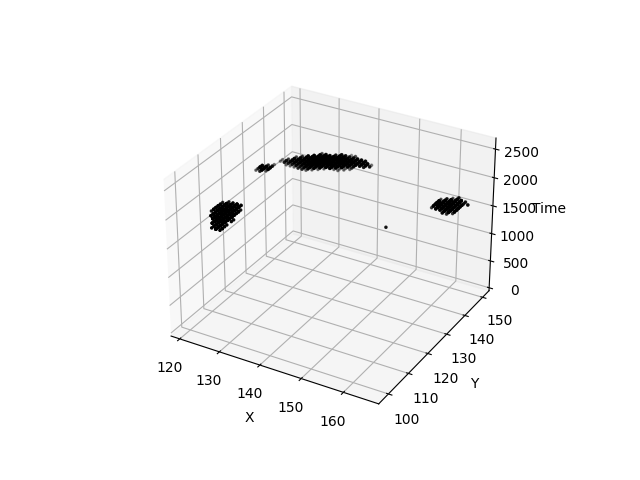

In [159]:
# Plot the xyz coordinates
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xyz_coords[:,0], xyz_coords[:,1], xyz_coords[:,2], c='black', marker='.', s = 10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Time')
ax.set_zlim(0, matrix.shape[2])

plt.show()

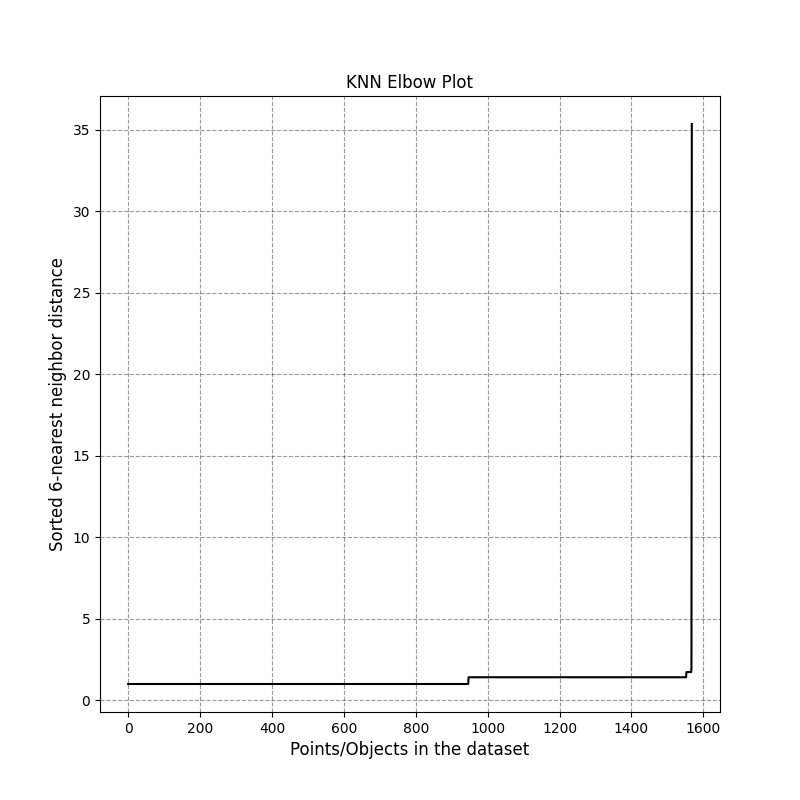

In [160]:
## knn on the new matrix to determine epsilon w min points = 6 (dim *2 sanders et al)
## make plot of this chart to choose value at elbow
# https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf
# https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd 
# https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan

k = 6

nbrs = NearestNeighbors(n_neighbors=k, radius=1).fit(xyz_coords)

# For each point, compute distances to its k-nearest neighbors
distances, indices = nbrs.kneighbors(xyz_coords) 
                                    
distances = np.sort(distances, axis=0)
distances = distances[:, k-1]

# Plot the sorted K-nearest neighbor distance for each point in the dataset
plt.figure(figsize=(8,8))
plt.plot(distances, color = 'black')
plt.title('KNN Elbow Plot')
plt.xlabel('Points/Objects in the dataset', fontsize=12)
plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
plt.grid(True, linestyle="--", color='black', alpha=0.4)
plt.show()
# plt.close()


In [110]:
## try silhouette score as well 
## https://towardsdatascience.com/dbscan-clustering-algorithm-how-to-build-powerful-density-based-models-21d9961c4cec 

# from sklearn.cluster import DBSCAN # for building a clustering model
# from sklearn import metrics # for calculating Silhouette score
# # k = 6


# S=[] # this is to store Silhouette scores
# comb=[] # this is to store combinations of epsilon / min_samples

# # Define ranges to explore
# eps_range=range(6,12) # note, we will scale this down by 100 as we want to explore 0.06 - 0.11 range
# minpts_range=range(3,8)

# for kay in eps_range:
#     for j in minpts_range:
#         # Set the model and its parameters
#         model = DBSCAN(eps=kay/100, min_samples=j)
#         # Fit the model 
#         clm = model.fit(xyz_coords)
#         print(len(clm.labels_))
#         # Calculate Silhoutte Score and append to a list
#         S.append(metrics.silhouette_score(xyz_coords, clm.labels_, metric='euclidean'))
#         comb.append(str(kay)+"|"+str(j)) # axis values for the graph

# # Plot the resulting Silhouette scores on a graph
# plt.figure(figsize=(16,8), dpi=300)
# plt.plot(comb, S, 'bo-', color='black')
# plt.xlabel('Epsilon/100 | MinPts')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score based on different combnation of Hyperparameters')
# plt.show()


In [161]:
# use that epsilon and min neighbor = 6 to do dbscan on 3d data
# https://towardsdatascience.com/dbscan-clustering-algorithm-how-to-build-powerful-density-based-models-21d9961c4cec

from sklearn.cluster import DBSCAN # for building a clustering model

# First model: eps=0.08, MinPts=3
model_154_6 = DBSCAN(eps=1.73, # default=0.5, The maximum distance between two samples for one to be considered as in the neighborhood of the other.
               min_samples=6, # default=5, The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
               metric='euclidean', # default='euclidean'. The metric to use when calculating distance between instances in a feature array. 
               metric_params=None, # default=None, Additional keyword arguments for the metric function.
               algorithm='auto', # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’, The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors.
               leaf_size=30, # default=30, Leaf size passed to BallTree or cKDTree.
               p=None, # default=None, The power of the Minkowski metric to be used to calculate distance between points. If None, then p=2
               n_jobs=None, # default=None, The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
              )


labels_154_6 = model_154_6.fit(xyz_coords)

n_clusters = len(set(labels_154_6.labels_)) - (1 if -1 in labels_154_6.labels_ else 0)
n_noise = list(labels_154_6.labels_).count(-1)
print(n_clusters)
print(n_noise)


5
1


In [162]:
# plot color coded data
# plot number of centroids at different temperatures
model_154_6_arr  = np.append(xyz_coords, labels_154_6.labels_.reshape(-1, 1), axis=1)
print(model_154_6_arr.shape)


(1569, 4)


In [163]:
import plotly.express as px # for data visualization


df = pd.DataFrame(model_154_6_arr, columns=['x', 'y', 'z', 'labels'])

df=df.sort_values(by=['labels'])

# Create a 3D scatter plot
fig = px.scatter_3d(df, x=df['x'], y=df['y'], z=df['z'], 
                    opacity=1, color=df['labels'].astype(str), 
                    color_discrete_sequence=['black']+px.colors.qualitative.Plotly,
                    width=900, height=900
                   )

# Update chart looks
fig.update_layout(#title_text="Scatter 3D Plot",
                  showlegend=True,
                  legend=dict(orientation="h", yanchor="bottom", y=0.04, xanchor="left", x=0.1),
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                        center=dict(x=0, y=0, z=-0.2),
                                        eye=dict(x=1.5, y=1.5, z=0.5)),
                                        margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         ),
                               yaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                          ),
                               zaxis=dict(backgroundcolor='lightgrey',
                                          color='black', 
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         )))
# Update marker size
fig.update_traces(marker=dict(size=4))

fig.show()
